<a href="https://colab.research.google.com/github/Amrit1Gurung/Medical-Speciality-Prediction/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import numpy as np  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re, string
from nltk import word_tokenize, sent_tokenize

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/content/drive/My Drive/programs/Datasets/Medical Transcriptions/preprocessedData.csv')
data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,cleaned_transcription
0,0,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",mode left atrial enlargement left atrial diame...
1,1,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",left ventricular cavity size wall thickness ap...
2,2,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...",echocardiogram multiple views heart great vess...
3,3,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...",description normal cardiac chambers size norma...
4,4,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...",study mild aortic stenosis widely calcified mi...


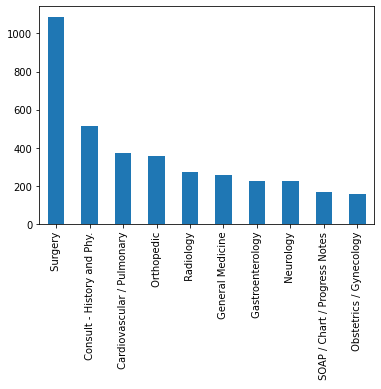

In [4]:
data.medical_specialty.value_counts().plot(kind='bar')

class imbalance seen


In [5]:
# creating feature vectors and target vector
transcripts = data.cleaned_transcription.values
Y = data.medical_specialty.values

In [6]:
# label encode our categorical target variable
le = LabelEncoder()
Y = le.fit_transform(Y)

In [7]:
Y

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
# function to create document-term matrix
def create_vec(strings):
  #tf = TfidfVectorizer(analyzer="char_wb", ngram_range=(1,3))
  tf = TfidfVectorizer(max_features = 6000, ngram_range=(1,3), min_df=5, max_df=0.9)
  tf.fit(strings)
  X = tf.fit_transform(strings)
  return X
vecs = create_vec(transcripts)

In [9]:
vecs

<3630x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 721484 stored elements in Compressed Sparse Row format>

In [10]:
# applying SMOTE oversampling method to upsampe minority class labels
sm = SMOTE()
x_res, y_res = sm.fit_resample(vecs,Y)

In [13]:
df = pd.DataFrame({"class":list(y_res)})
df.head()

,class
0,0
1,0
2,0
3,0
4,0


In [14]:
df['class'].value_counts()

7    1088
6    1088
5    1088
4    1088
3    1088
2    1088
9    1088
1    1088
8    1088
0    1088
Name: class, dtype: int64

In [15]:
# Splitting data into train:test by 80:20
x_train, x_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.2, random_state = 42)

In [17]:
x_train = x_train.toarray()
print('\nTraining features shape: ',x_train.shape)

x_val =x_val.toarray()
print('Test features shape:     ',x_val.shape)


Training features shape:  (8704, 6000)
Test features shape:      (2176, 6000)


In [18]:
# a function to train and evaluate model
def train_model(model, x_train,x_val,y_train,y_val):
  model.fit(x_train,y_train)
  prediction = model.predict(x_val)
  print('Accuracy',round(accuracy_score(prediction, y_val)*100, 0),'%')
  return model

### Logistic Regression

In [19]:
classifier = LogisticRegression(multi_class='multinomial', solver='sag')
logreg = train_model(classifier, x_train, x_val, y_train, y_val)

Accuracy 69.0 %


### Support Vector Machine

In [20]:
classifier = SVC(C = 2.5, kernel = 'linear', gamma='auto', random_state=42)
svm = train_model(classifier, x_train, x_val, y_train, y_val)

Accuracy 70.0 %


### Random Forest Classifier

In [22]:
classifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 10, random_state = 42)
rf = train_model(classifier, x_train, x_val, y_train, y_val)

Accuracy 64.0 %


**Among the three classifier above, SVM have a highest accuracy so we shall use it to draw out the classification reports....**

In [24]:
prediction = svm.predict(x_val)
print('Classification report for Support Vector Machine: \n', classification_report(prediction,y_val,target_names=list(le.classes_)))

Classification report for Support Vector Machine: 
                                 precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.73      0.66      0.69       261
    Consult - History and Phy.       0.33      0.59      0.42       116
              Gastroenterology       0.93      0.76      0.84       240
              General Medicine       0.74      0.67      0.70       231
                     Neurology       0.77      0.64      0.70       255
       Obstetrics / Gynecology       0.99      0.79      0.88       260
                    Orthopedic       0.77      0.69      0.73       242
                     Radiology       0.56      0.56      0.56       235
 SOAP / Chart / Progress Notes       0.91      0.80      0.85       264
                       Surgery       0.29      0.88      0.43        72

                      accuracy                           0.70      2176
                     macro avg       0.70      0.70      0.68      2176
          

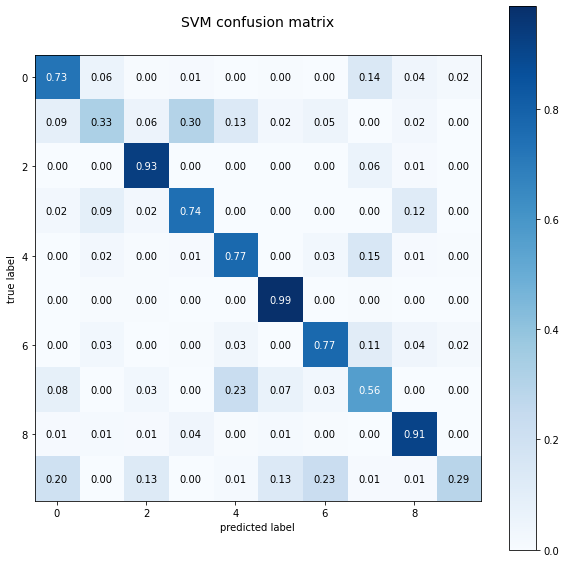

In [26]:
# CREATING THE CONFUSION MATRIX
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_val, prediction),
                                colorbar = True,
                                show_absolute = False,
                                show_normed = True,
                                figsize = (10,10))
plt.title("SVM confusion matrix", fontsize=14)
plt.show()